> ## **Recommendation By Search 🔍**
> This model uses RNN-LSTM as a text processing method, to be trained and evaluated with evaluation metrics (accuracy, precision, recall, and F1 score) and confusion matrix, to generate accurate recommendations based on the user's search problem input.

### Import Library

In [1]:
!pip install Sastrawi

In [38]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Input Data

In [4]:
df = pd.read_csv('text.csv')

In [5]:
df.head()

,text
0,perbaikan atap bocor
1,perbaikan atap rembes
2,perbaikan genteng bocor
3,perbaikan atap asbes
4,pemasangan genteng


### Explore Data

In [12]:
# Explore data (preprocessing)
# tokenizing, lowercasing, remove stopwords, stemming dan bersihkan karakter khusus

# inisialisasi StopWordRemover dan Stemmer
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# fungsi cleaning text dari karakter khusus dan angka
def remove_special_characters_and_numbers(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

df['tokenized_text'] = df['text'].apply(word_tokenize)
df['lowercased_text'] = df['text'].str.lower()
df['stopwords_removed'] = df['lowercased_text'].apply(lambda x: stopword_remover.remove(x))
df['stemmed_text'] = df['stopwords_removed'].apply(lambda x: stemmer.stem(x))
df['cleaned_text'] = df['stemmed_text'].apply(remove_special_characters_and_numbers)

In [18]:
# ubah cleaned_text jadi dictionary

from collections import Counter
def create_dictionary(text):
    return dict(Counter(text.split()))

df['cleaned_text_dict'] = df['cleaned_text'].apply(create_dictionary)
df.head()

,text,tokenized_text,lowercased_text,stopwords_removed,stemmed_text,cleaned_text,cleaned_text_dict
0,perbaikan atap bocor,"[perbaikan, atap, bocor]",perbaikan atap bocor,perbaikan atap bocor,baik atap bocor,baik atap bocor,"{'baik': 1, 'atap': 1, 'bocor': 1}"
1,perbaikan atap rembes,"[perbaikan, atap, rembes]",perbaikan atap rembes,perbaikan atap rembes,baik atap rembes,baik atap rembes,"{'baik': 1, 'atap': 1, 'rembes': 1}"
2,perbaikan genteng bocor,"[perbaikan, genteng, bocor]",perbaikan genteng bocor,perbaikan genteng bocor,baik genteng bocor,baik genteng bocor,"{'baik': 1, 'genteng': 1, 'bocor': 1}"
3,perbaikan atap asbes,"[perbaikan, atap, asbes]",perbaikan atap asbes,perbaikan atap asbes,baik atap asbes,baik atap asbes,"{'baik': 1, 'atap': 1, 'asbes': 1}"
4,pemasangan genteng,"[pemasangan, genteng]",pemasangan genteng,pemasangan genteng,pasang genteng,pasang genteng,"{'pasang': 1, 'genteng': 1}"


In [17]:
# gabungkan dictionary

combined_dictionary = Counter()

for index, row in df.iterrows():
    combined_dictionary.update(row['cleaned_text_dict'])

# konversi kembali ke dictionary
seed_text = dict(combined_dictionary)
print(seed_text)

{'baik': 53, 'atap': 19, 'bocor': 14, 'rembes': 1, 'genteng': 8, 'asbes': 1, 'pasang': 40, 'baja': 1, 'ringan': 2, 'jasa': 45, 'isolasi': 1, 'plafon': 2, 'ganti': 28, 'cat': 6, 'ulang': 4, 'pudar': 1, 'tambal': 8, 'bongkar': 5, 'dak': 1, 'beton': 1, 'talang': 7, 'air': 34, 'kerangka': 2, 'awat': 1, 'metal': 2, 'roofing': 1, 'kaca': 5, 'polikarbonat': 1, 'plank': 1, 'pasir': 1, 'sirap': 1, 'kayu': 9, 'ulin': 1, 'upvc': 1, 'keramik': 6, 'glazur': 1, 'seng': 1, 'alumunium': 1, 'wc': 2, 'sumbat': 4, 'instalasi': 22, 'pompa': 6, 'sambung': 2, 'pipa': 13, 'keran': 4, 'rusak': 13, 'baru': 8, 'salur': 12, 'mampet': 3, 'kamar': 1, 'mandi': 2, 'bersih': 4, 'drainase': 1, 'closet': 1, 'bak': 1, 'shower': 2, 'buang': 2, 'hujan': 1, 'luap': 1, 'sumur': 2, 'kotor': 3, 'pecah': 3, 'genang': 1, 'mati': 1, 'limbah': 1, 'halang': 1, 'tutup': 1, 'parah': 1, 'retak': 3, 'dinding': 13, 'plester': 1, 'reparasi': 4, 'lantai': 5, 'grouting': 1, 'wallpaper': 2, 'halus': 1, 'lembab': 1, 'kelupas': 1, 'segel': 2

In [16]:
# buat word index (mapping kata ke indeks unik)

word_index = {word: index for index, word in enumerate(seed_text)}
print(word_index)

{'baik': 0, 'atap': 1, 'bocor': 2, 'rembes': 3, 'genteng': 4, 'asbes': 5, 'pasang': 6, 'baja': 7, 'ringan': 8, 'jasa': 9, 'isolasi': 10, 'plafon': 11, 'ganti': 12, 'cat': 13, 'ulang': 14, 'pudar': 15, 'tambal': 16, 'bongkar': 17, 'dak': 18, 'beton': 19, 'talang': 20, 'air': 21, 'kerangka': 22, 'awat': 23, 'metal': 24, 'roofing': 25, 'kaca': 26, 'polikarbonat': 27, 'plank': 28, 'pasir': 29, 'sirap': 30, 'kayu': 31, 'ulin': 32, 'upvc': 33, 'keramik': 34, 'glazur': 35, 'seng': 36, 'alumunium': 37, 'wc': 38, 'sumbat': 39, 'instalasi': 40, 'pompa': 41, 'sambung': 42, 'pipa': 43, 'keran': 44, 'rusak': 45, 'baru': 46, 'salur': 47, 'mampet': 48, 'kamar': 49, 'mandi': 50, 'bersih': 51, 'drainase': 52, 'closet': 53, 'bak': 54, 'shower': 55, 'buang': 56, 'hujan': 57, 'luap': 58, 'sumur': 59, 'kotor': 60, 'pecah': 61, 'genang': 62, 'mati': 63, 'limbah': 64, 'halang': 65, 'tutup': 66, 'parah': 67, 'retak': 68, 'dinding': 69, 'plester': 70, 'reparasi': 71, 'lantai': 72, 'grouting': 73, 'wallpaper': 

In [11]:
# tampilkan total indeks akhir

total_index = len(word_index)
print(f"Total index: {total_index}")

Total index: 167


### Klasifikasi Decision Logic

In [ ]:
# 1. Inisialisasi Contoh Data dan kategori
texts = [
    "perbaikan atap bocor",
    "saluran air mampet",
    "bongkar pasang keramik",
    "instalasi listrik rumah",
    "perbaikan engsel pintu"
]
labels = ["Reparasi atap", "Reparasi saluran air", "Reparasi lantai dan dinding", "Instalasi listrik", "Reparasi aksesoris"]

# 2. Daftar kata kunci untuk setiap kategori
category_keywords = {
    "Reparasi atap": ["genteng", "atap", "bocor", "tetesan", "plafon", "baja ringan", "asbes"],
    "Reparasi saluran air": ["saluran", "air", "pipa", "mampet", "keran", "wastafel", "septic tank", "water heater"],
    "Reparasi lantai dan dinding": ["dinding", "lantai", "keramik", "retak", "pecah", "cat", "lembab", "wallpaper", "marmer"],
    "Instalasi listrik": ["kabel", "listrik", "lampu", "arus", "sambungan", "CCTV", "WiFi", "genset", "AC"],
    "Reparasi aksesoris": ["pintu", "jendela", "meja", "kursi", "pagar", "kusen", "gorden", "alumunium"]
}

In [ ]:
# 3. Buat fungsi deteksi kata kunci dalam teks
def detect_keywords(text, category_keywords):
    words = text.lower().split()
    keyword_features = []
    for category, keywords in category_keywords.items():
        keyword_features.append(int(any(keyword in words for keyword in keywords)))
    return keyword_features

In [ ]:
# 4. Vektorisasi TF-IDF
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(texts)

X_keywords = np.array([detect_keywords(text, category_keywords) for text in texts])
X_combined = np.hstack([X_text.toarray(), X_keywords])

In [ ]:
# 5. Klasifikasi dengan MLPClassifier
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
nn_model.fit(X_combined, labels)

# Fungsi klasifikasi berbasis decision logic
def classify_with_decision_logic(text, category_keywords, vectorizer, nn_model):
    keyword_features = detect_keywords(text, category_keywords) # Deteksi berdasarkan kata kunci

    for idx, feature in enumerate(keyword_features):
        if feature == 1:
            return list(category_keywords.keys())[idx]
        
    text_vectorized = vectorizer.transform([text])
    text_combined = np.hstack([text_vectorized.toarray(), np.array([keyword_features])])
    predicted_category = nn_model.predict(text_combined)

    return predicted_category[0]

# 6. Testing
new_text = "pemasangan listrik ac"
predicted_category = classify_with_decision_logic(new_text, category_keywords, vectorizer, nn_model)

print(f"Teks '{new_text}' termasuk dalam kategori: {predicted_category}")

### Klasifikasi RNN

In [ ]:
# 1. Inisialisasi Contoh Data dan kategori
texts = [
    "perbaikan atap bocor",
    "saluran air mampet",
    "bongkar pasang keramik",
    "instalasi listrik rumah",
    "perbaikan engsel pintu"
]
labels = ["Reparasi atap", "Reparasi saluran air", "Reparasi lantai dan dinding", "Instalasi listrik", "Reparasi aksesoris"]

# 2. Daftar kata kunci untuk setiap kategori
category_keywords = {
    "Reparasi atap": ["genteng", "atap", "bocor", "tetesan", "plafon", "baja ringan", "asbes"],
    "Reparasi saluran air": ["saluran", "air", "pipa", "mampet", "keran", "saluran wastafel", "septictank", "water heater"],
    "Reparasi lantai dan dinding": ["dinding", "lantai", "keramik", "retak", "pecah", "cat", "dinding lembab", "wallpaper", "marmer"],
    "Instalasi listrik": ["kabel", "listrik", "lampu", "arus", "sambungan", "instalasi CCTV", "instalasi WiFi", "genset", "instalasi AC"],
    "Reparasi aksesoris": ["pintu", "jendela", "meja", "kursi", "pagar", "kusen", "gorden", "alumunium"]
}

In [ ]:
# 3. Tokenisasi dan padding untuk teks
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)

# Padding untuk memastikan semua input memiliki panjang yang sama
max_sequence_length = 10  # Panjang maksimal
X_padded = tf.keras.utils.pad_sequences(X, maxlen=max_sequence_length, padding='post')

# 4. Encoding label untuk kategori
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [ ]:
# 5. Model Neural Network (LSTM)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length),
    tf.keras.layers.LSTM(64),  # LSTM layer untuk menangkap urutan kata
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer: softmax untuk multi-class classification
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# 6. Pelatihan model
history = model.fit(X_padded, y, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2000 - loss: 1.6144
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0000e+00 - loss: 1.6083
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4000 - loss: 1.6017
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2000 - loss: 1.6173
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2000 - loss: 1.6096
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2000 - loss: 1.6058
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0000e+00 - loss: 1.6091
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2000 - loss: 1.5934
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2000 - loss: 1.6067
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2000 - loss: 1.5845
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4000 - loss: 1.5935
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.20

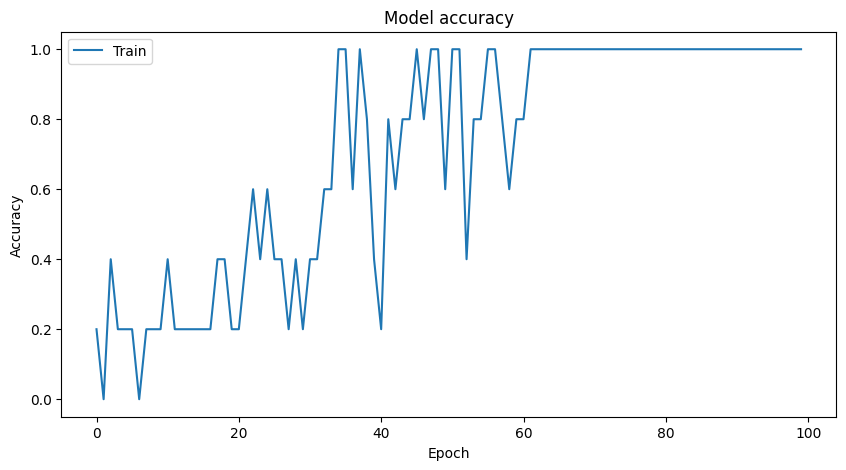

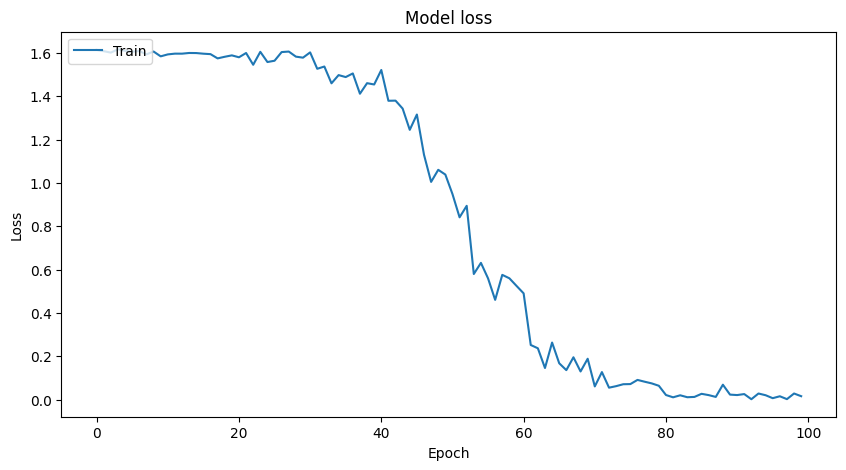

In [ ]:
# 7. Tampil plot loss dan akurasi

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# 8. Implementasi keyword matching untuk meningkatkan prediksi
def keyword_based_classifier(text, category_keywords, label_encoder):
    # Cek kategori berdasarkan kata kunci
    category_scores = {category: 0 for category in category_keywords}

    for category, keywords in category_keywords.items():
        # Hitung kemunculan kata kunci dalam teks
        category_scores[category] = sum([word in text.lower() for word in keywords])

    # Tentukan kategori berdasarkan skor tertinggi kata kunci
    keyword_based_prediction = max(category_scores, key=category_scores.get)

    # Konversi hasil keyword ke label numerik
    predicted_label = label_encoder.transform([keyword_based_prediction])[0]

    return predicted_label, keyword_based_prediction

In [ ]:
# 9. Kombinasi hasil model dengan keyword-based prediction
def combined_predict(text, model, tokenizer, label_encoder, category_keywords):
    # Prediksi dengan model LSTM
    text_seq = tokenizer.texts_to_sequences([text])
    text_padded = tf.keras.utils.pad_sequences(text_seq, maxlen=max_sequence_length, padding='post')
    lstm_prediction = model.predict(text_padded)
    predicted_label_lstm = np.argmax(lstm_prediction, axis=1)
    predicted_label_lstm = label_encoder.inverse_transform(predicted_label_lstm)[0]

    # Prediksi dengan keyword-based
    predicted_label_keywords, keyword_prediction = keyword_based_classifier(text, category_keywords, label_encoder)

    probabilities = model.predict(text_padded) # Prediksi probabilitas
    confidence_in_lstm = max(probabilities[0])  # Ambil nilai tertinggi sebagai tingkat kepercayaan

    if confidence_in_lstm > 0.8:
        return predicted_label_lstm, "Prediksi berdasarkan LSTM"
    else:
        return keyword_prediction, "Prediksi berdasarkan kata kunci"

In [ ]:
# 10. Testing
text_input = "keramik pecah"
predicted_label, message = combined_predict(text_input, model, tokenizer, label_encoder, category_keywords)

print(f"Teks: {text_input}")
print(f"Prediksi LSTM: {predicted_label}")
print(f"Pesan: {message}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Teks: keramik pecah
Prediksi LSTM: Reparasi lantai dan dinding
Pesan: Prediksi berdasarkan LSTM


### Evaluasi Model Klasifikasi RNN

In [36]:
# Menggunakan model RNN untuk membuat prediksi pada data input yang telah diproses
# Asumsikan X_padded adalah data input yang telah diproses dan siap digunakan oleh model RNN

# Prediksi probabilitas untuk setiap kelas menggunakan model RNN
y_pred_rnn_probs = model.predict(X_padded)

# Menentukan label prediksi berdasarkan indeks probabilitas tertinggi (kelas dengan skor tertinggi)
y_pred_rnn = np.argmax(y_pred_rnn_probs, axis=1)

# Mengubah label prediksi dari indeks numerik kembali ke nama kategori asli
y_pred_rnn = label_encoder.inverse_transform(y_pred_rnn)

# Mengonversi label prediksi kembali ke format numerik untuk evaluasi
y_pred_rnn_numeric = label_encoder.transform(list(y_pred_rnn))

# Menghitung metrik evaluasi model menggunakan label prediksi dan label sebenarnya (y)
accuracy_rnn = accuracy_score(y, y_pred_rnn_numeric)
precision_rnn = precision_score(y, y_pred_rnn_numeric, average='weighted')
recall_rnn = recall_score(y, y_pred_rnn_numeric, average='weighted')
f1_rnn = f1_score(y, y_pred_rnn_numeric, average='weighted')

# Tampil hasil evaluasi model RNN
print("\nEvaluasi Model RNN:")
print(f"Akurasi  : {accuracy_rnn:.4f}")
print(f"Presisi  : {precision_rnn:.4f}")
print(f"Recall   : {recall_rnn:.4f}")
print(f"F1-score : {f1_rnn:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Evaluasi Model RNN:
Akurasi  : 1.0000
Presisi  : 1.0000
Recall   : 1.0000
F1-score : 1.0000


### Error Analysis (Confusion Matrix)

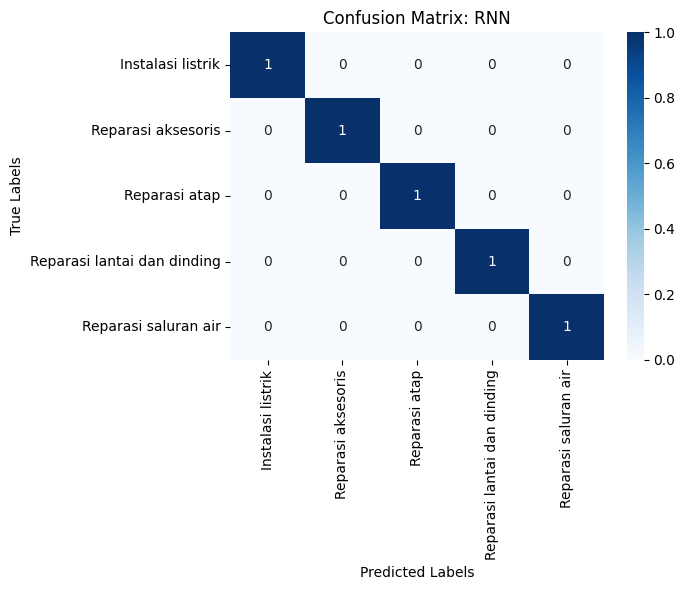

In [37]:
# Mengonversi prediksi model RNN (nama kategori) menjadi label numerik sebelum menghitung confusion matrix
y_pred_rnn_numeric = label_encoder.transform(list(y_pred_rnn))

# Menghitung confusion matrix untuk model RNN
cm_rnn = confusion_matrix(y, y_pred_rnn_numeric)

# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(12, 6))

# Plot confusion matrix untuk model RNN
plt.subplot(1, 2, 2)
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix: RNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

### Save Model

In [ ]:
# save model ke format .h5
model.save('rnn_model.h5')

In [ ]:
# save model .pkl dan konversi ke tfjs untuk deployment tanpa flask (opsional)

# Save the Decision Logic model
# filename_decision = 'dl_model.pkl'
# pickle.dump(nn_model, open(filename_decision, 'wb'))

# # Convert the RNN model to TensorFlow.js
# !pip install tensorflowjs

# !mkdir model_tfjs
# !tensorflowjs_converter --input_format keras rnn_model.h5 model_tfjs